## MPF training

Below is my test code to use MPF training for a fully-connected Boltzmann machine with 32 units with no GPU consideration.

In [37]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os
import timeit

%matplotlib inline

In [2]:
def load_data(dataset = '32-50K.npy', borrow = True):
    """
    Loads the dataset.
    """

    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)

    return dataset

In [29]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 16, temperature = 1,  W = None, b = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
        np.fill_diagonal(R, 0)

        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

        if not b:
            initial_b = np.asarray(np.random.rand(n), dtype = theano.config.floatX)
            b = theano.shared(initial_b, name = 'b', borrow = True)


        self.W = W
        self.b = b
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W, self.b]
    
#     def energy(): not sure if to have energy
    
    def cost(self, lr = 1e-2, epsilon = 1):
        """
        Returns cost when using vanilla SGD.
        """
        
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print ('Input size: {0}'.format(self.n))
#         print ('Optimizer: {0}'.format('vanilla'))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))
#         print (50 * '=')
        
#         cost =  epsilon * T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, T.fill_diagonal(self.W, 0)) + self.b)))
        cost =  epsilon * T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, T.fill_diagonal(self.W, 0)) + self.b) / self.temperature))
        gparams = T.grad(cost, self.params)

        updates = [(param, param - lr * gparam) \
        for param, gparam in zip(self.params, gparams)]

        return cost, updates

In [83]:
def trainmpf(units = 32, lr = 1e-3, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '32-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.cost(lr = lr, epsilon = epsilon)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
        b_learnt = flow.b.get_value(borrow = True)
        
        W = np.load(sample[0:2] + '-' + 'W' + '.npy')
        b = np.load(sample[0:2] + '-' + 'b' + '.npy')
        
        mseW = np.linalg.norm(W - W_learnt)/ (units**2 - units)/2
        mseb = np.linalg.norm(b - b_learnt)/ units
        mse = (mseW * mseb)/(mseW + mseb)
        
        if epoch%validate_every == 0:
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, mseb: %.5f, mse: %.5f Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW, mseb, mse, (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time

#     W_learnt = flow.W.get_value(borrow = True)
#     b_learnt = flow.b.get_value(borrow = True)

#     W = np.load(sample[0:2] + '-' + 'W' + '.npy')
#     b = np.load(sample[0:2] + '-' + 'b' + '.npy')
#     print (W.shape, b.shape)
#     print (W_learnt.shape, b_learnt.shape)
    Wb = np.concatenate((W, b.reshape(units, -1)), axis = 1)
    Wb_learnt = np.concatenate((W_learnt, b_learnt.reshape(units, -1)), axis = 1)
    plt.figure(figsize = (8,8)) 
    plt.imshow(Wb - Wb_learnt, interpolation='none')
    plt.colorbar()
    
    print ('The training took %.2f minutes' % (training_time/60.))

########################MPF########################
Input size: 32
Learning temperature: 1
Learning rate: 0.001
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 6.460717 mseW: 0.01334, mseb: 0.23231, mse: 0.01261 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.513084 mseW: 0.01161, mseb: 0.21324, mse: 0.01101 Time Elasped: 0.45 
Training epoch 200/1000, Cost: 0.489952 mseW: 0.01084, mseb: 0.21089, mse: 0.01031 Time Elasped: 0.89 
Training epoch 300/1000, Cost: 0.478082 mseW: 0.01030, mseb: 0.20945, mse: 0.00982 Time Elasped: 1.33 
Training epoch 400/1000, Cost: 0.471072 mseW: 0.00988, mseb: 0.20844, mse: 0.00944 Time Elasped: 1.78 
Training epoch 500/1000, Cost: 0.466540 mseW: 0.00955, mseb: 0.20767, mse: 0.00913 Time Elasped: 2.22 
Training epoch 600/1000, Cost: 0.463413 mseW: 0.00927, mseb: 0.20705, mse: 0.00887 Time Elasped: 2.66 
Training epoch 700/1000, Cost: 0.461144 mseW: 0.00903, mseb: 0.20652, mse: 0.00865 Time Elasped: 3.10 
Training epoch 800/1000, Cost: 0.459432 ms

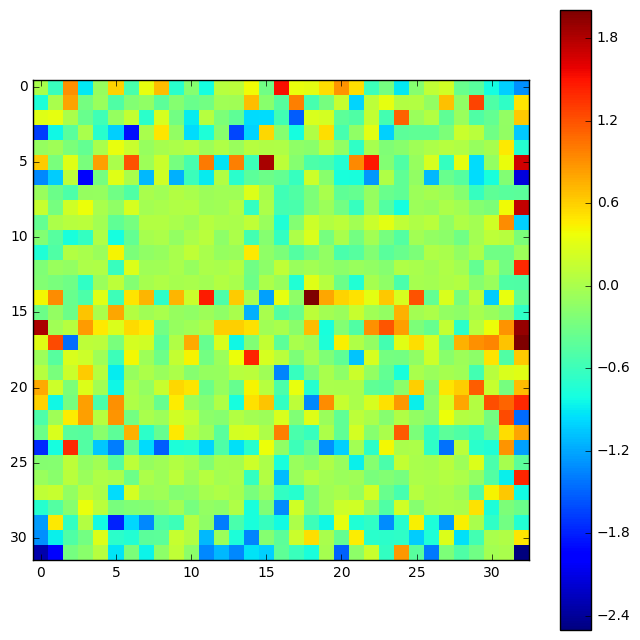

In [85]:
trainmpf()

########################MPF########################
Input size: 32
Learning temperature: 10
Learning rate: 0.001
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 1.109220 mseW: 0.01491, mseb: 0.25544, mse: 0.01409 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.898109 mseW: 0.01385, mseb: 0.22079, mse: 0.01304 Time Elasped: 0.49 
Training epoch 200/1000, Cost: 0.790700 mseW: 0.01377, mseb: 0.20655, mse: 0.01291 Time Elasped: 0.97 
Training epoch 300/1000, Cost: 0.726867 mseW: 0.01410, mseb: 0.20284, mse: 0.01318 Time Elasped: 1.44 
Training epoch 400/1000, Cost: 0.685334 mseW: 0.01460, mseb: 0.20465, mse: 0.01363 Time Elasped: 1.91 
Training epoch 500/1000, Cost: 0.656571 mseW: 0.01515, mseb: 0.20922, mse: 0.01413 Time Elasped: 2.36 
Training epoch 600/1000, Cost: 0.635693 mseW: 0.01571, mseb: 0.21510, mse: 0.01464 Time Elasped: 2.82 
Training epoch 700/1000, Cost: 0.619962 mseW: 0.01624, mseb: 0.22147, mse: 0.01513 Time Elasped: 3.26 
Training epoch 800/1000, Cost: 0.607743 m

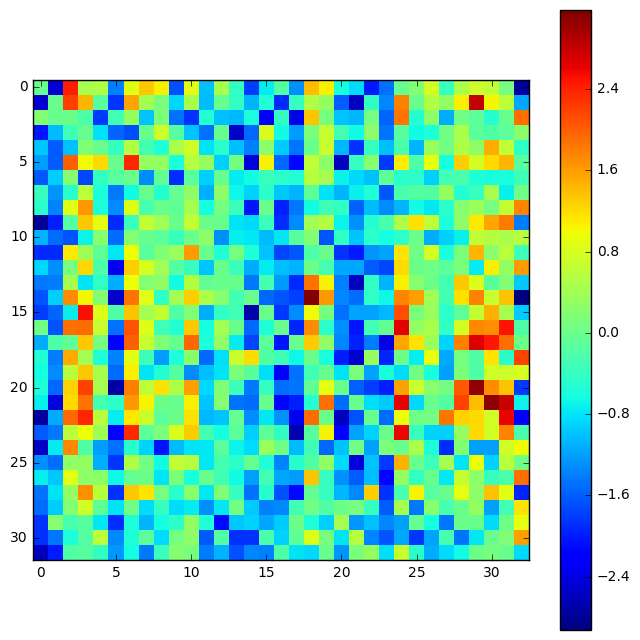

In [86]:
trainmpf(temperature = 10)

########################MPF########################
Input size: 32
Learning temperature: 100
Learning rate: 0.001
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 1.000801 mseW: 0.01472, mseb: 0.23744, mse: 0.01386 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.998912 mseW: 0.01464, mseb: 0.23437, mse: 0.01378 Time Elasped: 1.06 
Training epoch 200/1000, Cost: 0.997036 mseW: 0.01456, mseb: 0.23145, mse: 0.01370 Time Elasped: 1.64 
Training epoch 300/1000, Cost: 0.995172 mseW: 0.01450, mseb: 0.22868, mse: 0.01363 Time Elasped: 2.22 
Training epoch 400/1000, Cost: 0.993319 mseW: 0.01444, mseb: 0.22608, mse: 0.01358 Time Elasped: 2.75 
Training epoch 500/1000, Cost: 0.991479 mseW: 0.01440, mseb: 0.22365, mse: 0.01353 Time Elasped: 3.23 
Training epoch 600/1000, Cost: 0.989651 mseW: 0.01436, mseb: 0.22138, mse: 0.01348 Time Elasped: 3.71 
Training epoch 700/1000, Cost: 0.987834 mseW: 0.01433, mseb: 0.21929, mse: 0.01345 Time Elasped: 4.19 
Training epoch 800/1000, Cost: 0.986029 

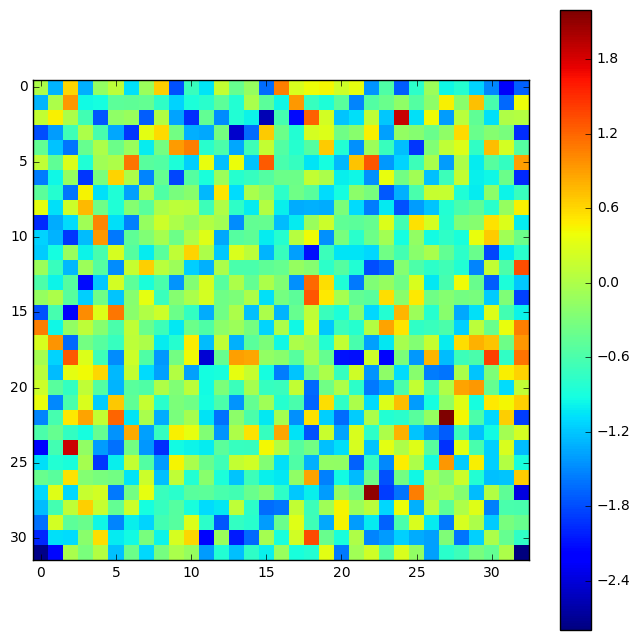

In [87]:
trainmpf(temperature=100)

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.001
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 2.708559 mseW: 0.02719, mseb: 0.26159, mse: 0.02463 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.691867 mseW: 0.01805, mseb: 0.20156, mse: 0.01657 Time Elasped: 0.34 
Training epoch 200/1000, Cost: 0.674068 mseW: 0.01437, mseb: 0.19402, mse: 0.01338 Time Elasped: 0.69 
Training epoch 300/1000, Cost: 0.667688 mseW: 0.01216, mseb: 0.18736, mse: 0.01142 Time Elasped: 1.03 
Training epoch 400/1000, Cost: 0.664753 mseW: 0.01064, mseb: 0.18129, mse: 0.01005 Time Elasped: 1.39 
Training epoch 500/1000, Cost: 0.663168 mseW: 0.00951, mseb: 0.17571, mse: 0.00902 Time Elasped: 1.81 
Training epoch 600/1000, Cost: 0.662209 mseW: 0.00862, mseb: 0.17053, mse: 0.00821 Time Elasped: 2.16 
Training epoch 700/1000, Cost: 0.661580 mseW: 0.00790, mseb: 0.16571, mse: 0.00754 Time Elasped: 2.50 
Training epoch 800/1000, Cost: 0.661140 ms

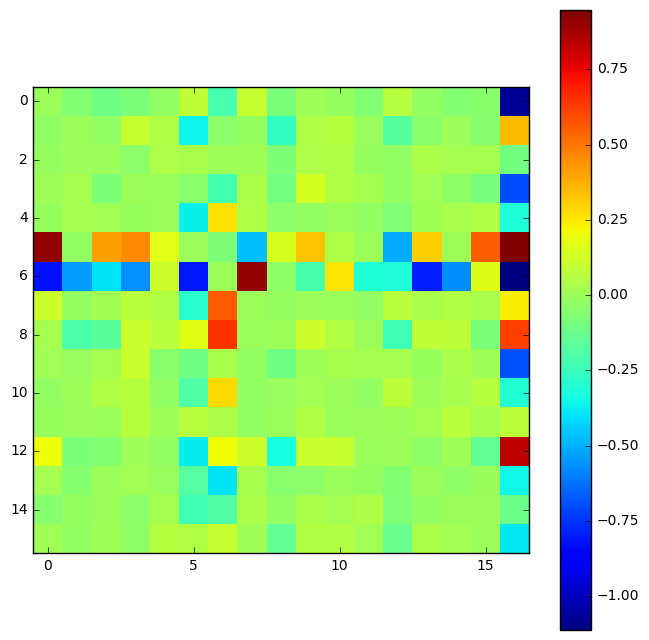

In [93]:
trainmpf(units = 16, lr = 1e-3, epsilon = 1, n_epochs = 1000, batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')